# NAO example notebook

This notebook contains an example of access of ERA5 data with the `Reader` class and evaluation of the NAO teleconnection (station based index) with `aqua` libraries and an example of the plotting routines.

In [1]:
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from aqua import Reader
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import station_based_index
from plots import index_plot, reg_plot
from tools import load_namelist

## Teleconnection details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.
The field required to evaluate the teleconnection is also specified in the `namelist`. (WIP to be automatically fixed by the reader)

In [35]:
diagname  = 'teleconnections'
telecname = 'NAO'
model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_monthly_native'

namelist = load_namelist(diagname,configdir='../')

field = namelist[telecname]['field']

`namelist` contains now the detail about the teleconnections diagnostic.

## Retrieve data with the intake AQUA functionality

Data required for the NAO teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [37]:
configdir = '../../../config/'

reader = Reader(model=model,exp=exp,source=source,configdir=configdir,regrid='r025')

2023-05-29 10:45:39 :: Reader :: WARNING  -> Source grid: /work/bm1235/ifs-grids/tco_grids/tco1279_grid.nc
2023-05-29 10:45:39 :: Reader :: WARNING  -> Weights file not found: /work/bb1153/b382075/nextgems/weights/weights_IFS_tco1279-orca025-cycle3_2D_monthly_native_ycon_r025_l2d.nc
2023-05-29 10:45:39 :: Reader :: WARNING  -> Attempting to generate it ...
2023-05-29 10:46:37 :: Reader :: WARNING  -> Success!


In [38]:
data = reader.retrieve(var=field)
infile = data[field]
infile = reader.regrid(infile)

### Data preparation

The `Reader` returns a `Dataset`. It is needed to select the data for the desired variable and regrid before calling the library function.

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of index values.

In [39]:
nao = station_based_index(infile,namelist,telecname,months_window=3)
nao

<xarray.DataArray 'index' (time: 58)>
dask.array<getitem, shape=(58,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-02-15 2020-03-15 ... 2024-11-15
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 1 ... 1 2 3 4 5 6 7 8 9 10 11

The timeserie can be plot with the `index_plot` function from the `plots.py` file, already with some customization in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='index'>)

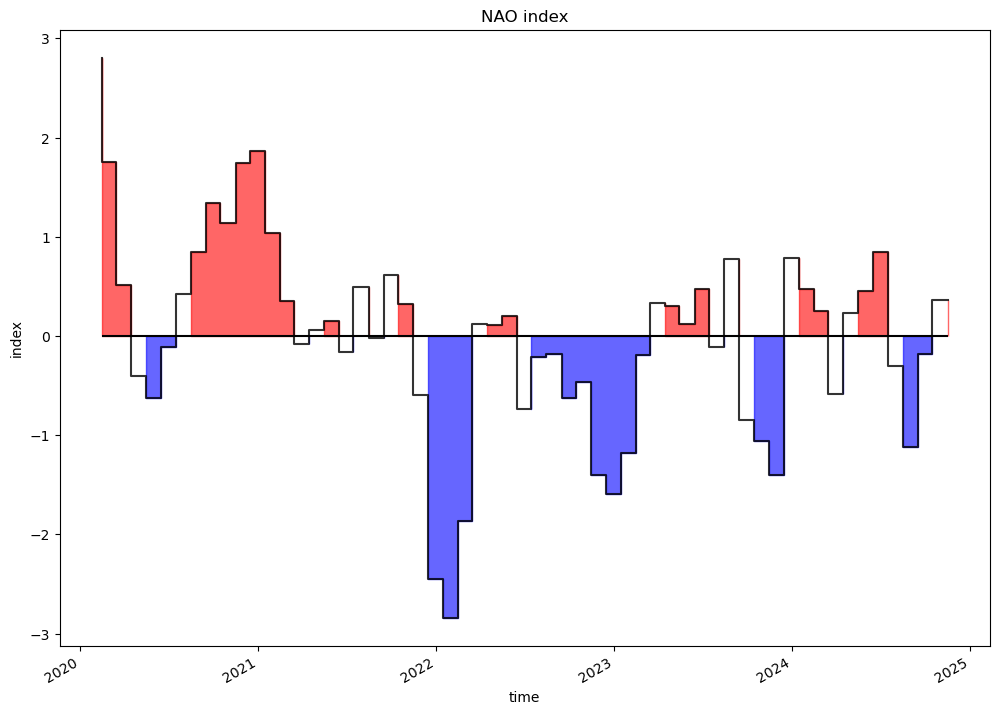

In [40]:
index_plot(nao,title='NAO index',save=True,filename='NAO_index.png',outputdir='../img/',xlabel='time')

## Regression plot

To visualize the teleconnection on a 2D plot, functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified, here the `LambertConformal` projection is used.

(<xarray.DataArray (lat: 720, lon: 1440)>
 dask.array<truediv, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

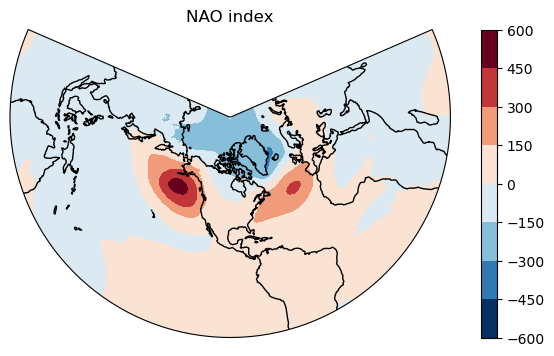

In [41]:
reg_plot(nao,infile,save=True,filename='NAO_reg.png',outputdir='../img/',projection_type='LambertConformal',
            title='NAO index',contour=True,levels=10)